In [1]:
import os
import subprocess
import numpy as np
import pandas as pd
import urllib.request, urllib.parse, json
import time
import tempfile
from rdkit import Chem
import datetime
#import multiprocess as mp

In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'

In [3]:
import openpyxl

In [4]:
df = pd.read_excel(raw_dir+'ICF_extractions_211223_wTIMES.xlsx', sheet_name = 'timesivt')

In [5]:
df['parent'] = df['Chemical name'].fillna(method = 'ffill')

/tmp/ipykernel_1827630/3726619019.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['parent'] = df['Chemical name'].fillna(method = 'ffill')


In [6]:
df['Chemical name'].nunique()
df['Parent'] = df['Chemical name'].apply(lambda x: 'Parent' if pd.notnull((x)) else np.nan)

In [7]:
def smi_inchi(x):
    mol = Chem.MolFromSmiles(x)
    clean_smi = Chem.MolToSmiles(mol, isomericSmiles=False)
    clean_mol = Chem.MolFromSmiles(clean_smi)
    inchi =     Chem.MolToInchi(clean_mol)
    inchi_key = Chem.InchiToInchiKey(inchi)
    return inchi_key

In [8]:
newlst = []

for i, group in df.groupby('#'):
    subset = group[['parent', 'Parent']]
    #print(i, subset)
    for x, y, z in zip(enumerate(range(0, len(subset['parent']))), subset['parent'], subset['Parent']):
        if z == 'Parent':
            newlst.append(y)
        elif z != 'Parent':
            newlst.append(y+'_m_'+str(x[0]))

In [9]:
len(newlst)

6282

In [10]:
df['ID'] = newlst

In [11]:
inchi_keys = {}
errors = []
for k,v in zip(df['ID'], df['SMILES']):
    try:
        X = smi_inchi(v)
    except Exception as error:
        errors.append(error)
    else:
        inchi_keys[k] = X

[13:45:52] WARNING: Omitted undefined stereo

[13:45:52] WARNING: Omitted undefined stereo

[13:45:52] WARNING: Omitted undefined stereo

[13:45:52] WARNING: Omitted undefined stereo

[13:45:52] WARNING: Omitted undefined stereo

[13:45:52] WARNING: Omitted undefined stereo

[13:45:52] WARNING: Omitted undefined stereo

[13:45:52] WARNING: Omitted undefined stereo

[13:45:52] WARNING: Omitted undefined stereo

[13:45:52] WARNING: Omitted undefined stereo

[13:45:52] WARNING: Omitted undefined stereo

[13:45:52] WARNING: Omitted undefined stereo

[13:45:52] WARNING: Omitted undefined stereo

[13:45:52] WARNING: Omitted undefined stereo

[13:45:52] WARNING: Omitted undefined stereo

[13:45:52] WARNING: Omitted undefined stereo

[13:45:52] WARNING: Omitted undefined stereo

[13:45:52] WARNING: Omitted undefined stereo

[13:45:52] WARNING: Omitted undefined stereo

[13:45:52] WARNING: Omitted undefined stereo

[13:45:52] WARNING: Omitted undefined stereo

[13:45:52] WARNING: Omitted undefi

In [12]:
len(inchi_keys)

6270

In [13]:
df_inchi = pd.DataFrame(inchi_keys.items(), columns = ['ID', 'INCHI_KEY'])

In [14]:
df2 = pd.merge(df, df_inchi, on = 'ID', how = 'left')

In [15]:
df2.head()

,#,ID of metabolite,Level of generation,Predecessor ID,CAS,Chemical name,SMILES,Observed map/metabolite,Transformation name,Transformation No,...,Transformation probability,Used probability,Enzyme(s),Quantity of metabolite,Total quantity of metabolite,Number of repetitions,parent,Parent,ID,INCHI_KEY
0,1,1,0,-,NaN,DTXSID4020298,Clc1ccccc1,NaN,NaN,NaN,...,NaN,NaN,NaN,0.003375,0.003375,1,DTXSID4020298,Parent,DTXSID4020298,MVPPADPHJFYWMZ-UHFFFAOYSA-N
1,1,2,1,1,NaN,NaN,Oc1ccccc1Cl,NaN,Aromatic C-Hydroxylation|Haloarene Aromatic C-...,322.0,...,0.85,0.3322,[E] 1.14.14.1 (CYP1A1;CYP2B1),0.004983,0.004983,1,DTXSID4020298,NaN,DTXSID4020298_m_1,ISPYQTSUDJAMAB-UHFFFAOYSA-N
2,1,5,2,2,NaN,NaN,Oc1ccc(O)cc1Cl,NaN,Aromatic C-Hydroxylation|Phenol C-Hydroxylation,216.0,...,0.90,0.5066,1.14.14.1 (CYP1A1;CYP1A2); 1.14.14.1 (CYP2B1;C...,0.082460,0.082460,1,DTXSID4020298,NaN,DTXSID4020298_m_2,AJPXTSMULZANCB-UHFFFAOYSA-N
3,1,7,3,5,NaN,NaN,OC1C(O)C(O)C(C(O)=O)OC1Oc1ccc(O)c(Cl)c1,NaN,"O-Glucuronidation|Alcohol, Phenol, Carboxylic ...",510.0,...,0.30,0.2550,2.4.1.17; 2.4.1.17 (UGT2B1;UGT2B12),0.042910,0.042910,1,DTXSID4020298,NaN,DTXSID4020298_m_3,WROXWNLBXJZRNE-UHFFFAOYSA-N
4,1,8,3,5,NaN,NaN,OC1C(O)C(O)C(C(O)=O)OC1Oc1ccc(O)cc1Cl,NaN,"O-Glucuronidation|Alcohol, Phenol, Carboxylic ...",510.0,...,0.30,0.2550,2.4.1.17; 2.4.1.17 (UGT2B1;UGT2B12),0.042910,0.042910,1,DTXSID4020298,NaN,DTXSID4020298_m_4,XXVBOGQUSBWILV-UHFFFAOYSA-N


In [16]:
df2[df2['INCHI_KEY'].isnull()]

,#,ID of metabolite,Level of generation,Predecessor ID,CAS,Chemical name,SMILES,Observed map/metabolite,Transformation name,Transformation No,...,Transformation probability,Used probability,Enzyme(s),Quantity of metabolite,Total quantity of metabolite,Number of repetitions,parent,Parent,ID,INCHI_KEY
4565,307,1,0,-,NaN,DTXSID5038913,CCN(CC)c1ccc(C(=C2C=CC(=[N+](.[Cl-])(CC)CC)C=C...,NaN,NaN,NaN,...,NaN,NaN,NaN,0.00000,0.0000,1,DTXSID5038913,Parent,DTXSID5038913,NaN
5036,343,3,0,1,NaN,NaN,OK,NaN,External Hydrolysis,568.0,...,1.0,1.0,NaN,1.00000,1.0000,1,DTXSID6029626,NaN,DTXSID6029626_m_2,NaN
5040,344,5,0,2,NaN,NaN,OK,NaN,External Hydrolysis,568.0,...,1.0,1.0,NaN,0.50000,0.5000,1,DTXSID2029745,NaN,DTXSID2029745_m_3,NaN
5165,356,1,0,-,NaN,DTXSID5027774,O=C1CN2CCN(CC(=O)[O-].[Na+])CC(=O)[O-].[Fe+3](...,NaN,NaN,NaN,...,NaN,NaN,NaN,0.00000,0.0000,1,DTXSID5027774,Parent,DTXSID5027774,NaN
5181,358,1,0,-,NaN,DTXSID7029742,OCCN1CCN2CC(=O)[O-].[Fe+3](.[O-]C(=O)C1).[O-]C...,NaN,NaN,NaN,...,NaN,NaN,NaN,0.00000,0.0000,1,DTXSID7029742,Parent,DTXSID7029742,NaN
5206,361,1,0,-,NaN,DTXSID9027815,[N+].[O-]C(=O)CN1CCN2CC(=O)[O-].[Fe+3](.[O-]C(...,NaN,NaN,NaN,...,NaN,NaN,NaN,0.00000,0.0000,1,DTXSID9027815,Parent,DTXSID9027815,NaN
5269,367,24,0,2,NaN,NaN,OK,NaN,External Hydrolysis,568.0,...,1.0,1.0,NaN,0.04762,0.2381,5,DTXSID00889574,NaN,DTXSID00889574_m_8,NaN
5270,367,25,0,2,NaN,NaN,OK,NaN,External Hydrolysis,568.0,...,1.0,1.0,NaN,0.04762,0.2381,5,DTXSID00889574,NaN,DTXSID00889574_m_9,NaN
5271,367,26,0,2,NaN,NaN,OK,NaN,External Hydrolysis,568.0,...,1.0,1.0,NaN,0.04762,0.2381,5,DTXSID00889574,NaN,DTXSID00889574_m_10,NaN
5272,367,27,0,2,NaN,NaN,OK,NaN,External Hydrolysis,568.0,...,1.0,1.0,NaN,0.04762,0.2381,5,DTXSID00889574,NaN,DTXSID00889574_m_11,NaN


In [17]:
df2['INCHI-KEY'] = df2[['INCHI_KEY', 'SMILES']].apply(lambda x: x[0] if pd.notnull((x[0])) else x[1], axis = 1)

/tmp/ipykernel_1827630/933535847.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df2['INCHI-KEY'] = df2[['INCHI_KEY', 'SMILES']].apply(lambda x: x[0] if pd.notnull((x[0])) else x[1], axis = 1)


In [18]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6282 entries, 0 to 6281
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   #                                 6282 non-null   int64  
 1   ID of metabolite                  6282 non-null   int64  
 2   Level of generation               6282 non-null   int64  
 3   Predecessor ID                    6282 non-null   object 
 4   CAS                               0 non-null      float64
 5   Chemical name                     468 non-null    object 
 6   SMILES                            6282 non-null   object 
 7   Observed map/metabolite           196 non-null    object 
 8   Transformation name               5814 non-null   object 
 9   Transformation No                 5814 non-null   float64
 10  Transformation ID                 5814 non-null   float64
 11  Transformation probability group  5814 non-null   float64
 12  Transf

In [19]:
df4 = df2[['parent','ID of metabolite','Predecessor ID','INCHI-KEY','Transformation name']]

In [20]:
import networkx as nx

In [21]:
def createGraphs(csv):
    metabolites = []
    chemicals = []
    reactions = []
    rows = csv.to_dict(orient='records')
    for row in rows:
        metabolites.append(row['INCHI-KEY'])
        chemicals.append(row['parent'])
        reactions.append(row['Transformation name'])

    chemicals = np.unique(chemicals)
    metabolites = np.unique(metabolites)
    reactions = np.unique(reactions)

    frames = []
    for chemical in chemicals:
        newFrame = pd.DataFrame()
        name = chemical
        for row in rows:
            if row['parent'] == name:
                newFrame = pd.concat([newFrame, pd.DataFrame([row])],ignore_index=True)
        frames.append(newFrame)

    graphs = []
    for chemical in frames:
        newGraph = nx.DiGraph()
        newGraph.name = chemical['parent'][0]
        nodeID = 0
        for i in range(len(chemical)):
            if i == 0:
                newGraph.add_node(nodeID,smile=chemical['INCHI-KEY'][i])
                nodeID += 1
            else:
                newGraph.add_node(nodeID,smile=chemical['INCHI-KEY'][i])
                newGraph.add_edge((int(chemical['Predecessor ID'][i])-1),int(nodeID),reaction=chemical['Transformation name'][i])
                nodeID += 1
        graphs.append(newGraph)
    print(str(len(graphs)) + ' metabolic graph objects created.')
    print(str(len(metabolites)) + ' unique metabolites generated in predictions.')
    print(str(len(reactions)) + ' unique reactions generating metabolites in predictions.')
    return graphs,metabolites 


In [22]:
a,b = createGraphs(df4)

468 metabolic graph objects created.
3257 unique metabolites generated in predictions.
107 unique reactions generating metabolites in predictions.


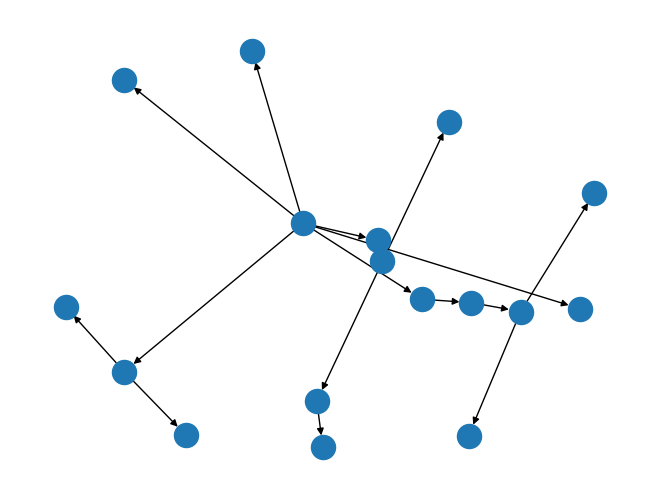

In [23]:
nx.draw(a[2])

In [24]:
graphNames = []
for graph in a:
    graphNames.append(graph.name)


In [25]:
import grakel
from grakel import Graph
from grakel import kernels 

In [26]:
gkGraphs = grakel.graph_from_networkx(a,node_labels_tag='smile')

In [27]:
WL = kernels.WeisfeilerLehman(normalize=True)

In [28]:
kernelScores = pd.DataFrame(WL.fit_transform(gkGraphs))
labels = list(np.arange(0,len(graphNames),1))
index = dict(zip(labels,graphNames))
kernelScores = kernelScores.rename(index=index)
kernelScores = kernelScores.rename(columns=index)

In [29]:
import seaborn as sns

<Axes: >

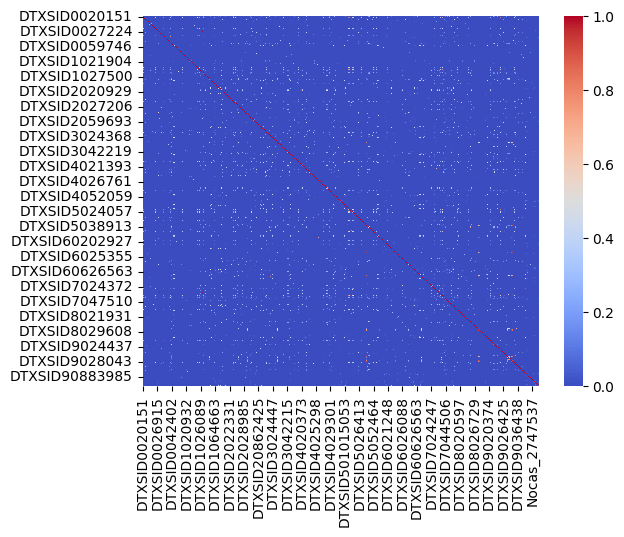

In [30]:
sns.heatmap(kernelScores, cmap = 'coolwarm')


In [31]:
kernelScores.to_csv(interim_dir+'WL_TIMES_290324.csv')

In [32]:
df2['Transformation name'].nunique()

106

In [33]:
pd.crosstab(df2['parent'], df2['Transformation name'] )

Transformation name,Acetylation|Hydroxamic Acid O-Acetylation,Acetylation|Primary Aromatic Amine N-Acetylation,Aliphatic C-Hydroxylation|(Omega-1) Oxidation,Aliphatic C-Hydroxylation|Alkanoic Acid Aliphatic C-Hydroxylation|2-Alkylalkanoic Acid Aliphatic C-Hydroxylation,Aliphatic C-Hydroxylation|Allylic Aliphatic C-Hydroxylation,Aliphatic C-Hydroxylation|Benzylic Hydroxylation,Aliphatic C-Hydroxylation|Branched Hydrocarbon Aliphatic C-Hydroxylation|Tertiary Hydrocarbon Aliphatic C-Hydroxylation,Aliphatic C-Hydroxylation|Cycloalkane Aliphatic C-Hydroxylation|Cyclohexane Aliphatic C-Hydroxylation,Aliphatic C-Hydroxylation|Cycloalkane Aliphatic C-Hydroxylation|Cyclopentane Aliphatic C-Hydroxylation,Aliphatic C-Hydroxylation|Dimethylsilane Aliphatic C-Hydroxylation,...,Quinone Methide Formation|4-Methylphenol Derivative Quinone Methide Formation,Reductive Dehalogenation|Haloalkane Reductive Dehalogenation|Geminal Dichloroalkane Reductive Dehalogenation,S-Glucuronidation|Thiol S-Glucuronidation,S-Oxidation|Sulfenic and Sulfinic Acid S-Oxidation,Sulfation|Benzyl Alcohol Sulfation,Sulfation|N-Hydroxylamine Sulfation,Sulfation|Phenol Sulfation,Sulfation|Primary Aromatic Amine Sulfation,Tautomerization|Imine-Enamine Tautomerization|Ketimine-Enamine Tautomerization,Thiol Oxidation|Sulfinic Acid Formation
parent,,,,,,,,,,,,,,,,,,,,,
DTXSID0020151,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID0020232,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID0020440,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID0020494,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID0020523,0,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pubchem_102283668,0,0,1,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Pubchem_138190,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Pubchem_162521585,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
mydict = {}
for i, group in df2.groupby('parent'):
    mydict[i] = len(group['ID'])


In [35]:
for index in df2[df2['Chemical name'].isin(list({k:v for k,v in mydict.items() if v ==1}.keys()))].index:
    df2.loc[index, 'Transformation name'] = 'no_metabolism'


In [36]:
df2[df2['Chemical name'].isin(list({k:v for k,v in mydict.items() if v ==1}.keys()))]

,#,ID of metabolite,Level of generation,Predecessor ID,CAS,Chemical name,SMILES,Observed map/metabolite,Transformation name,Transformation No,...,Used probability,Enzyme(s),Quantity of metabolite,Total quantity of metabolite,Number of repetitions,parent,Parent,ID,INCHI_KEY,INCHI-KEY
2034,132,1,0,-,NaN,DTXSID5047748,CP(O)(O)=O,NaN,no_metabolism,NaN,...,NaN,NaN,1.0,1.0,1,DTXSID5047748,Parent,DTXSID5047748,YACKEPLHDIMKIO-UHFFFAOYSA-N,YACKEPLHDIMKIO-UHFFFAOYSA-N
2387,150,1,0,-,NaN,DTXSID8047763,N#C[S-],NaN,no_metabolism,NaN,...,NaN,NaN,1.0,1.0,1,DTXSID8047763,Parent,DTXSID8047763,ZMZDMBWJUHKJPS-UHFFFAOYSA-M,ZMZDMBWJUHKJPS-UHFFFAOYSA-M
2408,155,1,0,-,NaN,DTXSID2024115,OC=O,NaN,no_metabolism,NaN,...,NaN,NaN,1.0,1.0,1,DTXSID2024115,Parent,DTXSID2024115,BDAGIHXWWSANSR-UHFFFAOYSA-N,BDAGIHXWWSANSR-UHFFFAOYSA-N
2646,173,1,0,-,NaN,DTXSID0023117,NC(N)=N,NaN,no_metabolism,NaN,...,NaN,NaN,1.0,1.0,1,DTXSID0023117,Parent,DTXSID0023117,ZRALSGWEFCBTJO-UHFFFAOYSA-N,ZRALSGWEFCBTJO-UHFFFAOYSA-N
2650,175,1,0,-,NaN,DTXSID2020711,Cl,NaN,no_metabolism,NaN,...,NaN,NaN,1.0,1.0,1,DTXSID2020711,Parent,DTXSID2020711,VEXZGXHMUGYJMC-UHFFFAOYSA-N,VEXZGXHMUGYJMC-UHFFFAOYSA-N
4778,319,1,0,-,NaN,DTXSID4026426,C[Si](Cl)(Cl)Cl,NaN,no_metabolism,NaN,...,NaN,NaN,1.0,1.0,1,DTXSID4026426,Parent,DTXSID4026426,JLUFWMXJHAVVNN-UHFFFAOYSA-N,JLUFWMXJHAVVNN-UHFFFAOYSA-N
4816,323,1,0,-,NaN,DTXSID10179211,C[Si](O)(O)O,NaN,no_metabolism,NaN,...,NaN,NaN,1.0,1.0,1,DTXSID10179211,Parent,DTXSID10179211,ZJBHFQKJEBGFNL-UHFFFAOYSA-N,ZJBHFQKJEBGFNL-UHFFFAOYSA-N
5421,384,1,0,-,NaN,DTXSID7025683,CN,NaN,no_metabolism,NaN,...,NaN,NaN,1.0,1.0,1,DTXSID7025683,Parent,DTXSID7025683,BAVYZALUXZFZLV-UHFFFAOYSA-N,BAVYZALUXZFZLV-UHFFFAOYSA-N
5590,405,1,0,-,NaN,DTXSID1021451,CC(=O)C(C(=O)Nc1ccccc1)N=Nc1ccc(-c2ccc(N=NC(C(...,NaN,no_metabolism,NaN,...,NaN,NaN,1.0,1.0,1,DTXSID1021451,Parent,DTXSID1021451,GNCOVOVCHIHPHP-UHFFFAOYSA-N,GNCOVOVCHIHPHP-UHFFFAOYSA-N
5626,407,1,0,-,NaN,DTXSID1021453,CC(=O)C(C(=O)Nc1cc(OC)c(Cl)cc1OC)N=Nc1ccc(-c2c...,NaN,no_metabolism,NaN,...,NaN,NaN,1.0,1.0,1,DTXSID1021453,Parent,DTXSID1021453,NKXPXRNUMARIMZ-UHFFFAOYSA-N,NKXPXRNUMARIMZ-UHFFFAOYSA-N


In [37]:
df_metab = pd.crosstab(df2['parent'], df2['Transformation name'] )

In [38]:
from scipy.spatial.distance import pdist, squareform


In [39]:
def distance_matrix(df):
    '''
    Function to create a pairwise square distance matrix using the Jaccard index
    '''
    D_mgrn = pd.DataFrame(squareform(pdist(df, 'jaccard')), columns = df.index, index = df.index)

    return D_mgrn

In [40]:
S_metab = 1-distance_matrix(df_metab)

In [41]:
S_metab.to_csv(interim_dir+'Stransformations_290324.csv')

In [42]:
df_metabs = pd.crosstab(df2['parent'], df2['INCHI-KEY'] )

In [43]:
S_metabs = 1-distance_matrix(df_metabs)

In [44]:
S_metabs.to_csv(interim_dir+'Smetabolites_290324.csv')

In [45]:
dfx = pd.read_excel(raw_dir+'ICF_extractions_211223.xlsx', index_col = [0])

In [46]:
rax_dict = {}
for i, group in dfx.groupby('Index'):
    v = list(set(group['DTXSID']))
    rax_dict[i] = v


In [47]:
len(rax_dict)

82

In [48]:
from collections import Counter

In [49]:
d = {k:len(v) for k,v in rax_dict.items()}


In [50]:
np.median(list(d.values()))
max(list(d.values()))

42

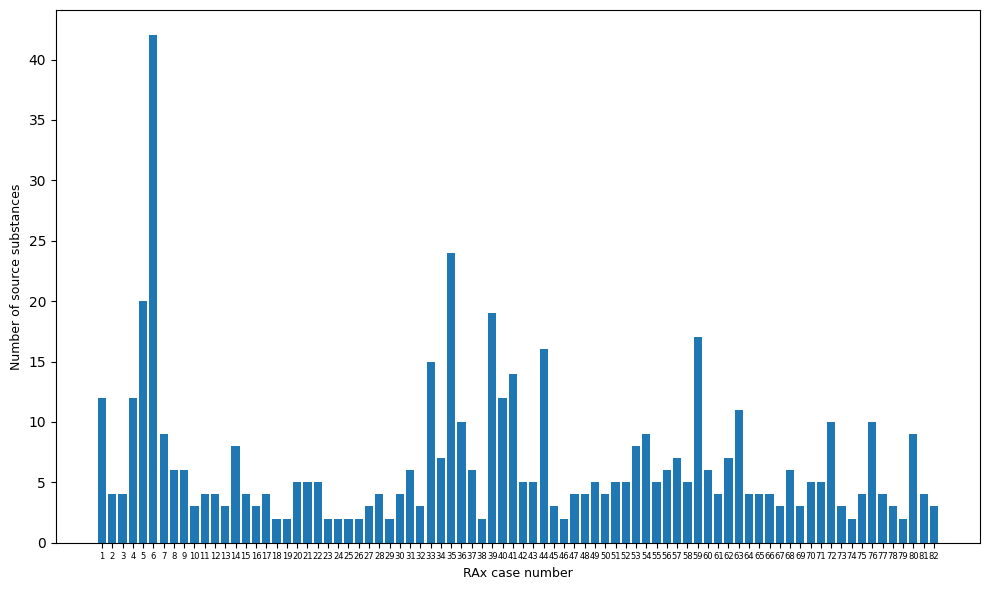

In [51]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize = (10,6))

names = list(d.keys())
values = list(d.values())

#empty_xtick_labels = [''] * len(current_xtick_labels)
#new_xtick_labels = [label if label in names else '' for label in current_xtick_labels]
#print(new_xtick_labels)
ax.bar(names, values)
#ax.invert_xaxis()
ax.set_xticks(names, labels = names, fontsize = 6)
ax.set_xlabel('RAx case number', fontsize = 9)
ax.set_ylabel('Number of source substances', fontsize = 9)
#plt.xticks(range(len(current_xtick_labels)), new_xtick_labels)
plt.tight_layout()
f.savefig(figures_dir+'membership_count.png', dpi = 300)

In [52]:
kernelScores

,DTXSID0020151,DTXSID0020232,DTXSID0020440,DTXSID0020494,DTXSID0020523,DTXSID0021597,DTXSID0021759,DTXSID0021836,DTXSID0021917,DTXSID0021965,...,DTXSID90961893,Nocas_2747537,Pubchem_102283661,Pubchem_102283662,Pubchem_102283665,Pubchem_102283668,Pubchem_138190,Pubchem_162521585,Pubchem_54176852,Pubchem_562248
DTXSID0020151,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.084515
DTXSID0020232,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
DTXSID0020440,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
DTXSID0020494,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
DTXSID0020523,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pubchem_102283668,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.072581,0.032258,0.072581,1.000000,0.0,0.0,0.056452,0.069284
Pubchem_138190,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000
Pubchem_162521585,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000
Pubchem_54176852,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.056452,0.0,0.0,1.000000,0.069284


In [53]:
my_dict = {}
for i, group in dfx.groupby('Index'):
    my_dict[i] = list(group['DTXSID'])

In [54]:
wl_dict = {}
for k,v in my_dict.items():
    try:
        v1 = kernelScores[kernelScores.index.isin(my_dict[k])] 
        v2 = v1[v1.columns.intersection(my_dict[k])]
        mk = np.triu(np.ones(v2.shape), k=0)
        b2 = v2.where(mk==1, np.nan).unstack().reset_index().dropna()
        b2 = b2[b2['level_0'] != b2['level_1']]
        b2 = b2.iloc[:,2].values
    except Exception as error:
        print(error)
    finally:
        wl_dict[k] = b2

In [55]:
trans_dict = {}
for k,v in my_dict.items():
    try:
        v1 = S_metab[S_metab.index.isin(my_dict[k])] 
        v2 = v1[v1.columns.intersection(my_dict[k])]
        v2.index.name = None
        v2.columns.name = None
        mk = np.triu(np.ones(v2.shape), k=0)
        a2 = v2.where(mk==1, np.nan).unstack().reset_index().dropna()
        a2 = a2[a2['level_0'] != a2['level_1']]
        a2 = a2.iloc[:,2].values
    except Exception as error:
        print(error)
    finally:
        trans_dict[k] = a2 

In [56]:
metabs_dict = {}
for k,v in my_dict.items():
    try:
        v1 = S_metabs[S_metabs.index.isin(my_dict[k])] 
        v2 = v1[v1.columns.intersection(my_dict[k])]
        v2.index.name = None
        v2.columns.name = None
        mk = np.triu(np.ones(v2.shape), k=0)
        b2 = v2.where(mk==1, np.nan).unstack().reset_index().dropna()
        b2 = b2[b2['level_0'] != b2['level_1']]
        b2 = b2.iloc[:,2].values
    except Exception as error:
        print(error)
    finally:
        metabs_dict[k] = b2

/home/grace/Documents/python/misc/cuda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/grace/Documents/python/misc/cuda/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


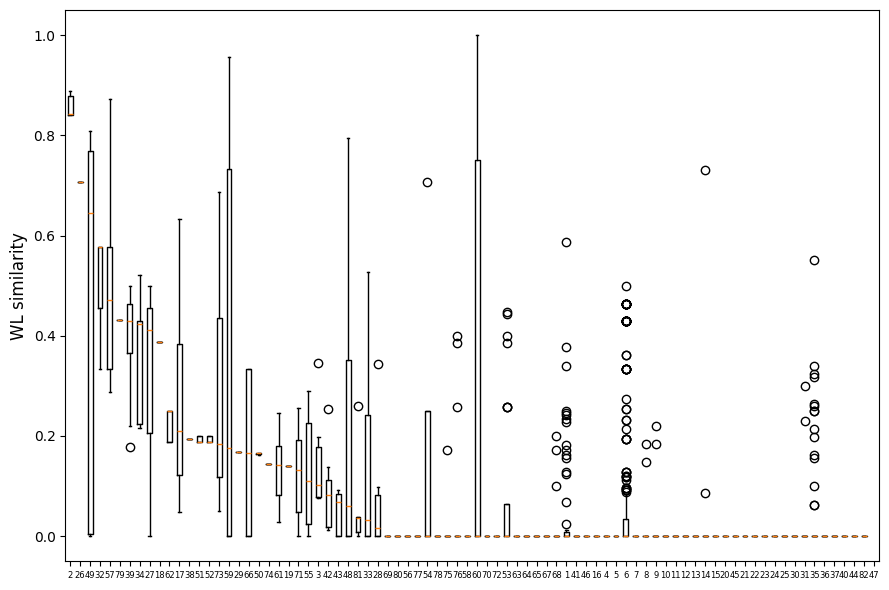

In [57]:
wl_df = pd.DataFrame({k:v for k,v in wl_dict.items() }.items())
wl_df['meds'] = [np.median(e) for e in wl_df[1]]
wl_df = wl_df.sort_values(by = 'meds', ascending = False)


fig, ax = plt.subplots(figsize = (9,6))
labels, data = list(zip((wl_df[0].values, wl_df[1].values)))
ax.boxplot(data[0], vert=True)  # Set vert=True to flip the axis

# Set x-axis ticks and labels
plt.xticks(range(1, len(labels[0]) + 1), labels[0], fontsize=6)
plt.ylabel('WL similarity', fontsize = 12)
plt.tight_layout()
fig.savefig(figures_dir+'WL similarity_200124.png', dpi = 300)

/home/grace/Documents/python/misc/cuda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/grace/Documents/python/misc/cuda/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


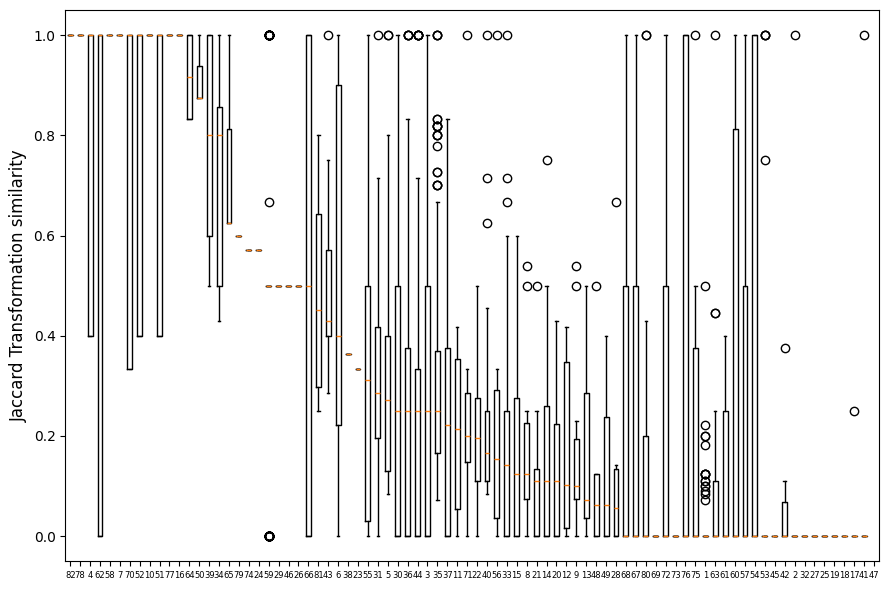

In [58]:
tr_df = pd.DataFrame({k:v for k,v in trans_dict.items() }.items())
tr_df['meds'] = [np.median(e) for e in tr_df[1]]
tr_df = tr_df.sort_values(by = 'meds', ascending = False)


fig, ax = plt.subplots(figsize = (9,6))
labels, data = list(zip((tr_df[0].values, tr_df[1].values)))
ax.boxplot(data[0], vert=True)  # Set vert=True to flip the axis

# Set x-axis ticks and labels
plt.xticks(range(1, len(labels[0]) + 1), labels[0], fontsize=6)
plt.ylabel('Jaccard Transformation similarity', fontsize = 12)
plt.tight_layout()
fig.savefig(figures_dir+'Jaccard transformation similarity_200124.png', dpi = 300)

/home/grace/Documents/python/misc/cuda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/grace/Documents/python/misc/cuda/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


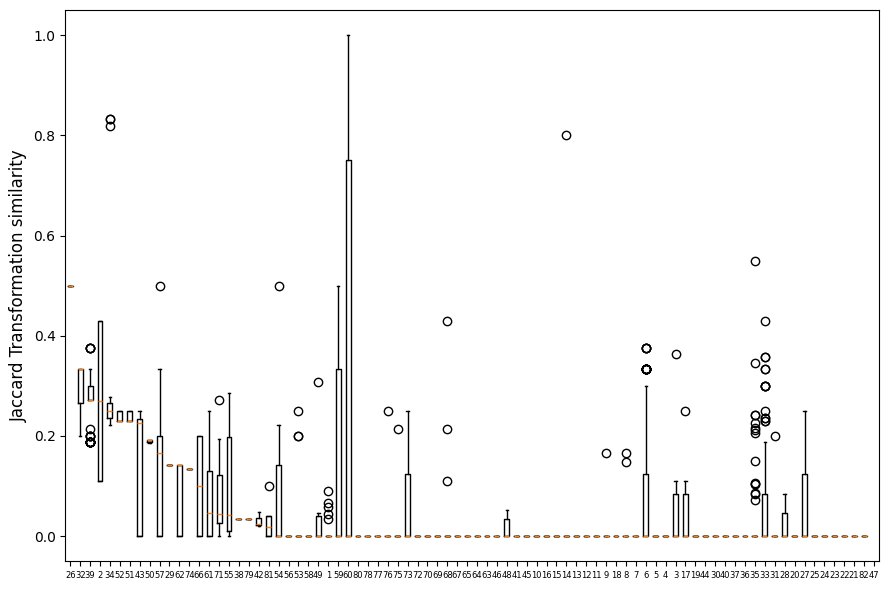

In [59]:
metab_df = pd.DataFrame({k:v for k,v in metabs_dict.items() }.items())
metab_df['meds'] = [np.median(e) for e in metab_df[1]]
metab_df = metab_df.sort_values(by = 'meds', ascending = False)


fig, ax = plt.subplots(figsize = (9,6))
labels, data = list(zip((metab_df[0].values, metab_df[1].values)))
ax.boxplot(data[0], vert=True)  # Set vert=True to flip the axis

# Set x-axis ticks and labels
plt.xticks(range(1, len(labels[0]) + 1), labels[0], fontsize=6)
plt.ylabel('Jaccard Transformation similarity', fontsize = 12)
plt.tight_layout()
fig.savefig(figures_dir+'Jaccard metabolites similarity_200124.png', dpi = 300)